## load data + cleaning

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def first_aid(df):
    temp = 'data/'+df+'.csv'
    df = pd.read_csv(temp , sep =',', names = list(range(0,30)))
    df = df[[4,0,5,1,2,3]+list(range(6,29))]
    df[5] = df[5].map(lambda x: x.lstrip('מספר תגובות -'))
    df.columns = ['url','data','number_comment','name','title']+list(range(1,25))
    return df

joy = first_aid('pain')
bowel_diseases = first_aid('bowel_diseases')
joints = first_aid('joints')
psoriasis = first_aid('psoriasis')
sclerosis = first_aid('sclerosis')

## organize data + future engineer
### Collect names in one column

In [3]:
def isNaN(num):
    #check if isNaN
    return num != num
def extract_name(dat,i,j):
    #get a cell, and extracts the name and response
    if not isinstance(dat,str):
        print('Mistake at point'+ str(i)+' ' + str(j) + 'Does not send string')
        return ['','']
    x1 = dat.find('XX')
    x2 = dat.rfind('XX')
    if x1 or x2 <0:
        print("Can't find Name"+ str(i) + "," + str(j))
        return['','']
    name = dat[x1+2:x2]
    text = dat[x2+2:]
    if len(name) > 30:
        print("Can't extract Name"+ str(i) + "," + str(j))
        return ['','']
    return [name,text]

def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele
        str1 += ","
    return str1
def organize_name(df):
    #Gets DF and deletes the responses from the names and centers them in one cell
    dim = df.shape
    for i in range(0,dim[0]):
        name = [df.loc[i,'name']]
        for j in range(6,dim[1]):
            dat = df.iloc[i,j]
            if not isNaN(dat):
                save_cell = extract_name(dat,i,j)
                df.iloc[i,j] = save_cell[1]
                name.append(save_cell[0])
            else:
                break
        df.loc[i,'name'] = listToString(name)
    return df
joy = organize_name(joy)
#bowel_diseases = organize_name(bowel_diseases)
#joints = organize_name(joints)
#psoriasis = organize_name(psoriasis)
#sclerosis = organize_name(sclerosis)

joy1 = joy.copy()

Can't extract Name121,9
Can't extract Name361,11


In [4]:
# regex tests #

# def signs(text):
#     start_loc = text.find('<.>')
#     r1 = ''.join(re.split("<.+?>",text))
#     r1 = ''.join(re.split("\S+@\S+",r1))
#     print(r1)
# #     print(start_loc)
#     print(text)
#     print('\n')
#     end_loc = text.find('>')
# #     print(start_loc)
# #     print(end_loc)
#     if start_loc > -1:
#         print(text)
#         print(text[:start_loc]+text[end_loc:])
#         print('#######################')
        
# # signs(joy.loc[:100,1])
# joy.loc[:6,1].apply(lambda x: signs(x) if type(x) != float else None)
# # joy[1].apply(lambda x: signs(x) if type(x) != float else None)

In [5]:
# regex tests #

# print(joy.loc[191,4])

# for i in range(2,24):
# # i=2
#     jo = joy[~joy[i].isna()]
#     # jo = jo.loc[79:533]
#     # jo = joy1.loc[25:76]
#     print(i)
#     display(jo[jo[i].str.contains('400(.+?)500')][i])
#     # jo.loc[173,1]

# ''.join(re.split("\d{2}\d*-\d{7}",joy.loc[135,i]))
# print(joy.loc[53,2])

### clean the text

In [6]:
import itertools

# def delete_prefixes(item,prefixes_word):
#     #Deleting section. Gets two words (in list) and deletes everything in between 
#     #Example for the need can be find at joy.iloc[13,5]
#     for word in prefixes_word:
#         loc1 = item.find(word[0])
#         loc2 = item.find(word[1])
#         #print(loc1,loc2)
#         while loc1 > 0 and loc2 > 0:
#             length_w = len(word[1])
#             item = item[:loc1] + item[loc2+length_w:]
#             loc1 = item.find(word[0])
#             loc2 = item.find(word[1])
#     return item



def delete_word(item,delete_list):
    # delete words form the cell
    for word in delete_list:
        item = ''.join(re.split(word,item))
        if word in item:
            loc = item.find(word)
            while loc > -1:
                length_w = len(word)
                item = item[:loc] + item[loc+length_w:]
                loc = item.find(word)
    return item

def multi_option_delete(item,multi_option):
    #Like delete_prefixes but for multiple selection.
    prefixes_word = list(itertools.product(*multi_option))
    item = delete_prefixes(item,prefixes_word)
    return item

def regex_remove(item,list_ex):
    for reg in list_ex:
        pattern = re.compile(reg)
        item = pattern.sub('', item)
    return item

def clean_df(item):
    #get cell and list of word that not allowed to be contain in the cell
    #return the cell clean
#     prefixes_word = [['<a','a>'],['<br >','<br>'],['<div','div>']]
    delete_list = ['&nbsp;','&quot;',"&#39;"]
    list_regex = ['<.+?>','\S*@\S*\s?','http\S+',"\d{2}\d*-\d{7}"]
    #list reg  = email         , web
    
    #multi_option = [['http','https'],['co.il','com']]
    if isNaN(item):
        return item
#     item = delete_prefixes(item,prefixes_word)
    item = delete_word(item,delete_list)
    #item = multi_option_delete(item,multi_option)
    item = regex_remove(item,list_regex)
    return item





def run_over_DF(df,fun):
#Unfortunately applymap run to MemoryError: in some case. This function overcomes this obstacle
    dim = df.shape
    for i in range(0,dim[0]):
    #for i in range(0,1000):
        if i % 100 == 0:
            print('#',i)
        for j in range(4,dim[1]):
            dat = fun(df.iloc[i,j])
            df.iloc[i,j] = dat
    return df
joy = run_over_DF(joy,clean_df)

#bowel_diseases = bowel_diseases.applymap(clean_df)
#joints = joints.applymap(clean_df)
#psoriasis = psoriasis.applymap(clean_df)
#sclerosis = sclerosis.applymap(clean_df)

# 0
# 100
# 200
# 300
# 400
# 500
# 600
# 700
# 800
# 900
# 1000
# 1100
# 1200
# 1300


## Visualization data


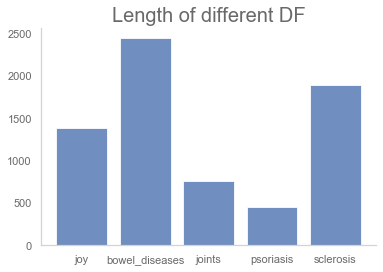

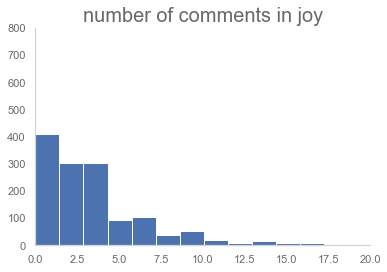

In [30]:
from add_style import *

table = [joy,bowel_diseases,joints,psoriasis,sclerosis]
x = []
for df in table:
    x.append(df.shape[0])
y=['joy','bowel_diseases','joints','psoriasis','sclerosis']
plt.bar(y, x, align='center', alpha=0.8)
plt.title("Length of different DF")
plt.show()

def hist_comment(df,name_DF):
    save = df['number_comment'].tolist()
    save = list(map(int, save))
    plt.hist(save,bins=50)
    plt.axis([0, 20, 0, 800])
    plt.title('number of comments in '+name_DF)
    plt.show()


hist_comment(joy,'joy')

In [11]:
def split_DF_to_word(df):
    #Gets DF and returns a list of the words from all columns and rows
    #Preparing to graph: plot_20_common
    dim = df.shape
    all_words = []
    for i in range(0,dim[0]):
        if i % 100 == 0:
            print('#',i)
        for j in range(4,dim[1]):
            dat = df.iloc[i,j]
            if not isNaN(dat):
                temp = dat.split()
                all_words = all_words + temp
            else:
                break
    return all_words

def clean_stop_word(lst,stop = ''):
    if len(stop) == 0:
        stop = list(pd.read_csv('heb_stopwords.txt', sep='\n', header=None)[0])
    temp = []
    for word in lst:
        if word not in stop:
            temp.append(word)
    return temp
temp = split_DF_to_word(joy)
temp = clean_stop_word(temp)

# 0
# 100
# 200
# 300
# 400
# 500
# 600
# 700
# 800
# 900
# 1000
# 1100
# 1200
# 1300


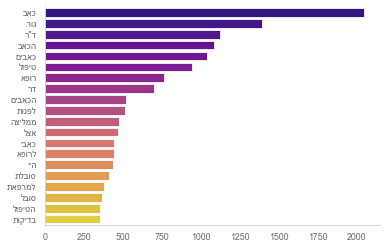

In [58]:
def invert_words_list(words_list):
    #Reverses the direction of the words so that the graphs in Hebrew will be readable
    return [word[::-1] for word in words_list]

def plot_common(words, n=20):
    #Gets text divided into tokens, pulls out a graph
    word_count = Counter(words)
    most=word_count.most_common(n)
    x, y= zip(*most)
    sns.barplot(x=y,y=invert_words_list(x),palette=("plasma"))
    sns.set_context("paper")

plot_common(temp, 20)

In [13]:
def invert_word(word):
    #Reverses the direction of the words so that the graphs in Hebrew will be readable
    return ' '.join([w[::-1] for w in word.split()][::-1])

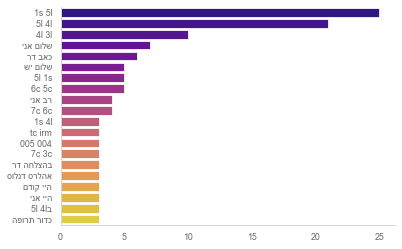

In [59]:
from langdetect import detect
def plot_top_ngrams_barchart(text, n=2):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:20]
    x,y=map(list,zip(*words_freq))
    temp = []
    for pair in x:
        heb_words = 0
        words = pair.split()
        for i in [0,1]:
            if not words[i].isnumeric() and detect(words[i]) == 'he': 
                heb_words += 1
                words[i] = invert_word(words[i])
        if heb_words == 2:
            words = words[::-1]
        temp.append(' '.join(words))
    sns.barplot(x=y,y=temp)
    sns.barplot(x=y,y=invert_words_list(x),palette=("plasma"))
    sns.set_context("paper")



plot_top_ngrams_barchart(temp,n=2)
#TODO: well, do you know how to make a graph, not to be one on another?


In [15]:
#TODO: בשוקה 86 הוא לא מטפל במקרים. אני חושב שזה בגלל שמופיע לפני נקודה. יתכן שכדי לשנות את הפונקציה של הנקיון. פתרון אלגני יותר יהיה להתשמש ברגקס
print(joy1.iloc[252  ,5])
print('##############################################')
print(joy.iloc[252  ,5])
print('##############################################')


<strong><em>במסגרת עבודת תזה אנו עורכים מחקר שמטרתו להבין גורמים למוטיבציה ולשחיקה בקרב בני זוג של חולים בכאב כרוני. בעזרת מילוי שאלון האורך כ-25 דקות (המצורף בקישור למטה), תוכלו לעזור לשפר את הידע הקיים בנושא ואולי בהמשך לשפר את הטיפול הניתן הן לחולים הסובלים מכאב כרוני והן לכם/ן, בני/בנות הזוג המטפלים/ות בהם.</em></strong><br />
<br />
<strong><em>הקישור למחקר:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp

### future functions